## Scrape data

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

# URL of the page to scrape
# url = "https://paperswithcode.com/sota/multi-task-language-understanding-on-mmlu" # MMLU
# url = "https://paperswithcode.com/sota/sentence-completion-on-hellaswag" # Hellaswag
url = "https://paperswithcode.com/sota/common-sense-reasoning-on-arc-challenge" # ARC

# Send a GET request to the URL
response = requests.get(url)

# Parse the HTML content
soup = BeautifulSoup(response.content, 'html.parser')
scripts = soup.find_all('script')

chart_data, table_metrics, table_data = scripts[6:9]

import json
json_table = json.loads(table_data.string)

df  = pd.DataFrame(json_table)
# MMLU
# df.to_csv('mmlu_data/mmlu_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['mmlu_accuracy'] = df.raw_metrics.apply(lambda x: x['Average (%)'])
# df.to_csv('mmlu_data/mmlu_benchmark_results_clean.csv', index=False)

# Hellaswag
# df.to_csv('hellaswag_data/hellaswag_benchmark_results.csv')
# df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
# df['hellaswag_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
# df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv', index=False)

# ARC
df.to_csv('arc_data/arc_benchmark_results.csv')
df = df.drop(columns=['table_id', 'mlmodel', 'mlmodeldetails', 'mlmodel_short', 'external_source_url', 'reports'])
df['arc_accuracy'] = df.raw_metrics.apply(lambda x: x['Accuracy'])
df.to_csv('arc_data/arc_benchmark_results_clean.csv', index=False)


In [18]:
import pandas as pd

# Read the datasets
mmlu_df = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')
arc_df = pd.read_csv('arc_data/arc_benchmark_results_clean.csv')
hellaswag_df = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean.csv')

# Function to strip whitespace and convert to lowercase
def clean_string(s):
    return s.strip().lower() if isinstance(s, str) else s

# Apply cleaning to method_short in all datasets
mmlu_df['method_short_clean'] = mmlu_df['method_short'].apply(clean_string)
arc_df['method_short_clean'] = arc_df['method_short'].apply(clean_string)
hellaswag_df['method_short_clean'] = hellaswag_df['method_short'].apply(clean_string)

# Create a dictionary mapping cleaned method_short to open_weights from MMLU dataset
open_weights_dict = dict(zip(mmlu_df['method_short_clean'], mmlu_df['open_weights']))

# Update ARC dataset
arc_df['open_weights'] = arc_df['method_short_clean'].map(open_weights_dict)

# Update Hellaswag dataset
hellaswag_df['open_weights'] = hellaswag_df['method_short_clean'].map(open_weights_dict)

# Remove the temporary cleaned column
arc_df = arc_df.drop(columns=['method_short_clean'])
hellaswag_df = hellaswag_df.drop(columns=['method_short_clean'])

# Save updated datasets
arc_df.to_csv('arc_data/arc_benchmark_results_clean_labeled.csv', index=False)
hellaswag_df.to_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv', index=False)

# Print some information about the updates
print(f"ARC dataset: {arc_df['open_weights'].notna().sum()} rows updated with open_weights")
print(f"Hellaswag dataset: {hellaswag_df['open_weights'].notna().sum()} rows updated with open_weights")

ARC dataset: 20 rows updated with open_weights
Hellaswag dataset: 19 rows updated with open_weights


In [11]:
# Did some manual labeling of whether weights were openly available or not -> new CSV file.
# this could probably be automated by checking against the names of the other dataset, but it wasn't standardized

## Plots

### Data Prep

In [ ]:
# 1. make a list of top max score for arc and hellaswag
# 2. make a plot with:
# - date on x-axis
# - y-axis is MMLU accuracy
# - scatter plot of all models
# - line plot of top open models
# - line plot of top closed model

# 3. interpolate missing data? 

In [1]:
import pandas as pd

# Set up the data
df_research = pd.read_csv('papers_with_models.csv')
df_released = pd.read_csv('Epoch Database - Notable Systems.csv')

df_research['date'] = pd.to_datetime(df_research['publication date (first revision)'])
df_research['year'] = pd.to_datetime(df_research['date']).dt.year
df_research['param count'] = pd.to_numeric(df_research['param count'], errors='coerce')
df_research['mmlu_accuracy'] = pd.to_numeric(df_research['mmlu_accuracy'], errors='coerce')
df_research['hellaswag_accuracy'] = pd.to_numeric(df_research['hellaswag_accuracy'], errors='coerce')
df_research['arc_accuracy'] = pd.to_numeric(df_research['arc_accuracy'], errors='coerce')
df_research['Type'] = 'Models used in research'

df_released['date'] = pd.to_datetime(df_released['Publication date'])
df_released['year'] = df_released['date'].dt.year
df_released['param count'] = pd.to_numeric(df_released['Parameters'], errors='coerce')
df_released['Type'] = 'Models released'

In [2]:
# Filter the published DataFrame to include only models from 2019 to 2024
df_released = df_released[(df_released['year'] >= 2019) & 
                            (df_released['year'] <= 2024)]

# Sort both DataFrames by date
df_research = df_research.sort_values(by='date')
df_published = df_released.sort_values(by='date')

# Filter for language models only
df_released = df_released[df_released['Domain'].str.contains('Language')]

# Filter for open models only 
df_released = df_released[df_released['Model accessibility'].str.contains('Open access', na=False)]

# Filter out rows with NaN in 'param_count'
df_released = df_released.dropna(subset=['param count'])

In [3]:
# Combine both DataFrames
df_combined = pd.concat([df_research[['year', 'date', 'param count', '' 'Type']], 
                         df_released[['year', 'date', 'param count', 'Type']]], ignore_index=True)

In [4]:
def get_max_list(df, metric='mmlu_accuracy'):
    max_score = 0
    max_score_list = []

    for i,x in df.iterrows():

        if x[metric] > max_score:
            max_score = x[metric]
            if len(max_score_list) == 0:
                max_score_list.append(x)
            else:
                if max_score_list[-1].evaluation_date == x.evaluation_date:
                    max_score_list[-1] = x
                else:
                    max_score_list.append(x)

    return max_score_list


### MMLU Plot

In [5]:
import pandas as pd
mmlu_df  = pd.read_csv('mmlu_data/mmlu_benchmark_results_clean_labeled.csv')

mmlu_df['evaluation_date'] = pd.to_datetime(mmlu_df['evaluation_date'])
mmlu_df = mmlu_df[['rank', 'method_short', 'evaluation_date', 'mmlu_accuracy', 'open_weights']]

open_mmlu_df = mmlu_df[mmlu_df.open_weights == True].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(mmlu_df.sort_values(by='evaluation_date', ascending=True))
max_open = get_max_list(open_mmlu_df)

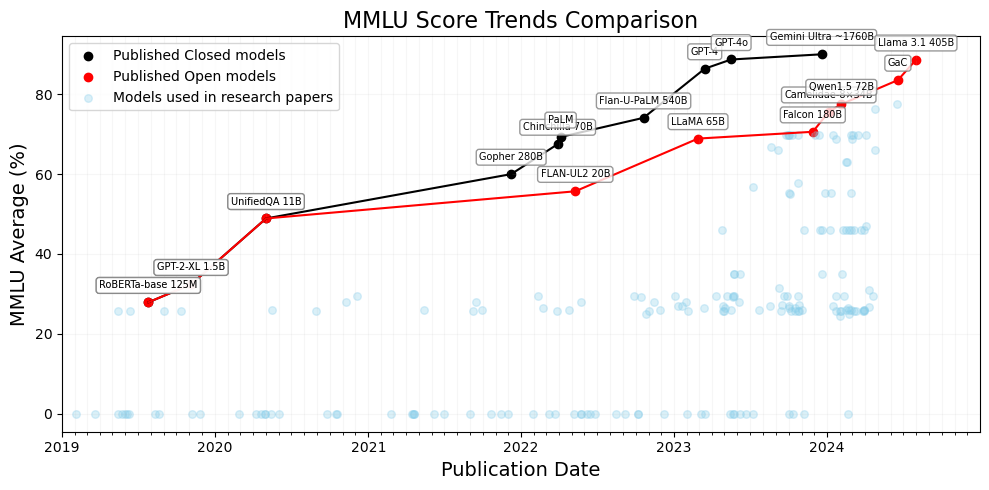

In [6]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.mmlu_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.mmlu_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['mmlu_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.mmlu_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.mmlu_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('MMLU Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("MMLU Average (%)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()


### Hellaswag Plot

In [23]:
import pandas as pd
hellaswag_df  = pd.read_csv('hellaswag_data/hellaswag_benchmark_results_clean_labeled.csv')

hellaswag_df['evaluation_date'] = pd.to_datetime(hellaswag_df['evaluation_date'])
hellaswag_df = hellaswag_df[['rank', 'method_short', 'evaluation_date', 'hellaswag_accuracy', 'open_weights']]

open_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == 'TRUE'].sort_values(by='evaluation_date', ascending=True)
closed_hellaswag_df = hellaswag_df[hellaswag_df.open_weights == 'FALSE'].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_hellaswag_df, metric='hellaswag_accuracy')
max_open = get_max_list(open_hellaswag_df, metric='hellaswag_accuracy')

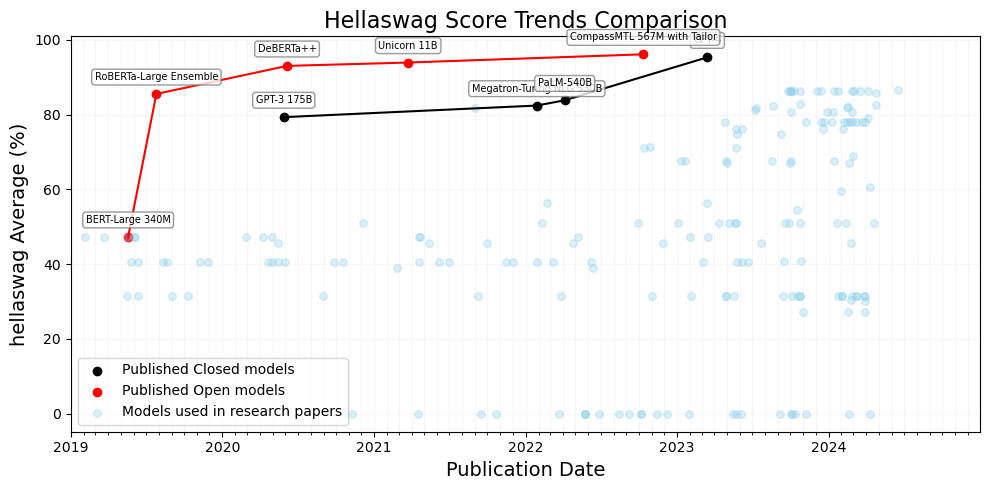

In [24]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.hellaswag_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.hellaswag_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['hellaswag_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.hellaswag_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('Hellaswag Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("hellaswag Average (%)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()

### ARC Plot

In [26]:
import pandas as pd
arc_df  = pd.read_csv('arc_data/arc_benchmark_results_clean_labeled.csv')

arc_df['evaluation_date'] = pd.to_datetime(arc_df['evaluation_date'])
arc_df = arc_df[['rank', 'method_short', 'evaluation_date', 'arc_accuracy', 'open_weights']]

open_arc_df = arc_df[arc_df.open_weights == 'TRUE'].sort_values(by='evaluation_date', ascending=True)
closed_arc_df = arc_df[arc_df.open_weights == 'FALSE'].sort_values(by='evaluation_date', ascending=True)

max_closed = get_max_list(closed_arc_df, metric='arc_accuracy')
max_open = get_max_list(open_arc_df, metric='arc_accuracy')

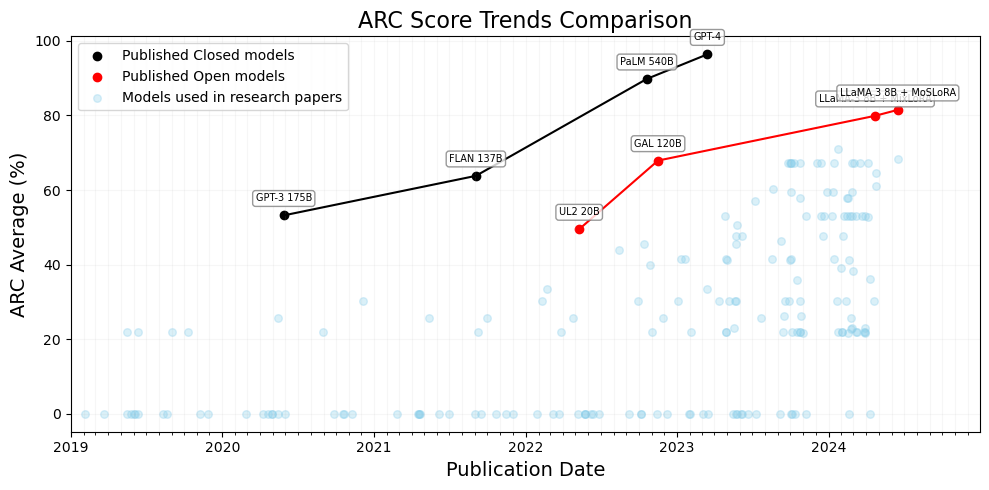

In [27]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt

# Set up the plot
plt.figure(figsize=(10, 5))
ax = plt.gca()

# Create scatter plot

plt.plot([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black')
plt.scatter([x.evaluation_date for x in max_closed], [x.arc_accuracy for x in max_closed], color='black', label='Published Closed models')

plt.plot([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red')
plt.scatter([x.evaluation_date for x in max_open], [x.arc_accuracy for x in max_open], color='red', label='Published Open models')

plt.scatter(df_research['date'], df_research['arc_accuracy'], 
            color='skyblue', alpha=0.3, s=30, label='Models used in research papers')


# plt.hlines(25, pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'), linestyles=['dashed'], color='black', alpha=0.3)

# Add annotations for max_score_list points
for i, point in enumerate(max_closed):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

for i, point in enumerate(max_open):
    plt.annotate(f"{point.method_short}", 
                 (point.evaluation_date, point.arc_accuracy),
                 textcoords="offset points",
                 xytext=(0,10),
                 ha='center',
                 fontsize=7,
                 bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.8))

# Set y-axis to logarithmic scale
# plt.yscale('log')

# Set labels and title
ax.set_title('ARC Score Trends Comparison', fontsize=16)
ax.set_xlabel('Publication Date', fontsize=14)
ax.set_ylabel("ARC Average (%)", fontsize=14)

# Customize the x-axis
ax.set_xlim(pd.Timestamp('2019-01-01'), pd.Timestamp('2024-12-31'))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax.xaxis.set_minor_locator(mdates.MonthLocator())

# Customize the grid
plt.grid(True, which="both", ls="-", alpha=0.1)

# Add legend
plt.legend()

# Show the plot
plt.tight_layout()
plt.show()